In [31]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import math
import time
import Apparatus as ap
import Algorithms as alg
import time
import copy
import scipy.misc as misc
%load_ext autoreload
%autoreload 1
%aimport Apparatus
%aimport Algorithms
%matplotlib inline
np.random.seed(1) # Reproducibility 
import pywt
plt.rcParams['figure.figsize'] = (16, 16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem Setup

In [32]:
## Regularizer for wavelet transformation
def reg(q, lamb):
    shape = q.shape
    q = q.reshape(512,512) 
    q = ap.SoftThreshComplex(ap.dwt2(q), lamb)
    q = ap.idwt2(q)
    return q.reshape(shape)

In [33]:
# image & mask prep
data = np.load('images/brain.npz')
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens']

# mid = len(im[0]) // 2 - 1
# fft = ap.fft2c(im)
# crop = fft[mid - 32:mid + 32:, mid - 32:mid + 32:]
# myImg = ap.ifft2c(crop)
# pdf = misc.imresize(pdf_vardens, (64,64))
# pdf = pdf / np.max(pdf.ravel())
# mask = ((np.random.rand(pdf.shape[0], pdf.shape[1]) < pdf)).astype(int)
# plt.figure(figsize=(16,4))
# plt.subplot(1,2,1)
# plt.title("mask")
# ap.imshowgray(mask)
# plt.subplot(1,2,2)
# plt.title("image")
# ap.imshowgray(np.abs(myImg))

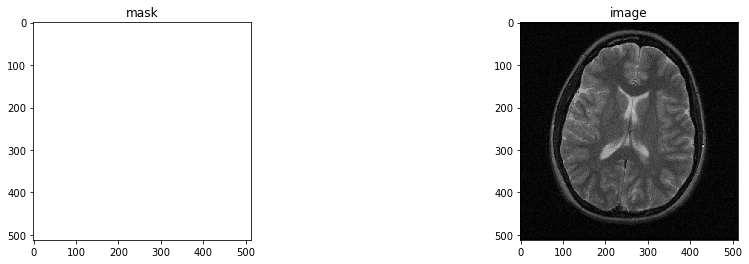

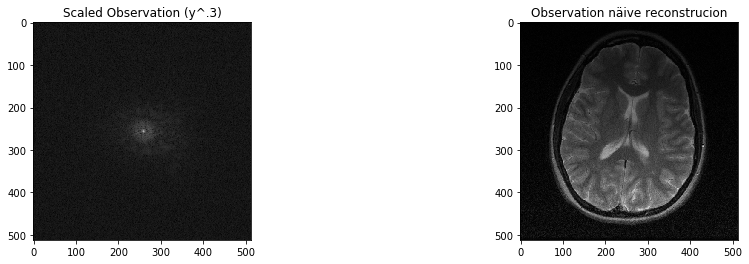

In [117]:
# mask
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("mask")
ap.imshowgray(mask_vardens,0,1)

# image
myImg = im
plt.subplot(1,2,2)
plt.title("image")
ap.imshowgray(np.abs(myImg))

# parameters
lamb = 0
dim = 2
N = 512

# initiate objects 
operatorObject = ap.Operator(ap.fft2c,ap.ifft2c,mask_vardens)   

# signal 
x = myImg.copy()

XX, YY = np.meshgrid(np.linspace(-1, 1, 512), np.linspace(-1, 1, 512))
x = x * np.exp(1j*10*XX + YY)  ## Added some phase shift
# plt.figure(figsize=(16,4))
# plt.subplot(1,2,1)
# plt.title('(fully sampled) K-Space')
# ap.imshowgray(np.abs(ap.fft2c(myImg)))

# forward oprator
y = x.copy()
y = operatorObject.A(y)
# plt.subplot(1,2,2)
# plt.title('Observation')
# ap.imshowgray(np.abs(y))

# Scaled Observation 
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title('Scaled Observation (y^.3)')
ap.imshowgray(np.abs(y**.3))

# Observation näive reconstrucion (ifft)
plt.subplot(1,2,2)
plt.title('Observation näive reconstrucion')
ap.imshowgray(np.abs(ap.ifft2c(y)))

# Passed Arguments 
params = {}
params['A'] = operatorObject.A
params['AT'] = operatorObject.AT
params['ATA'] = operatorObject.ATA
params['y'] = y
params['Reg'] = reg
params['lamb'] = lamb
params['N'] = N
params['dim'] = dim
params['signal'] = x
params['x_init'] = np.zeros(x.shape)

## ISTA

/Users/pagi/Research/MRI/bm4d-recon/Algorithms.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.x_init != None:


Iteration:  100
Initial True Error:  119.570244376
Final True Error:  2.5251325594
Initial Objective Error:  7148.52167007
Final Objective Error:  20.3288509223
Time:  45.30749273300171


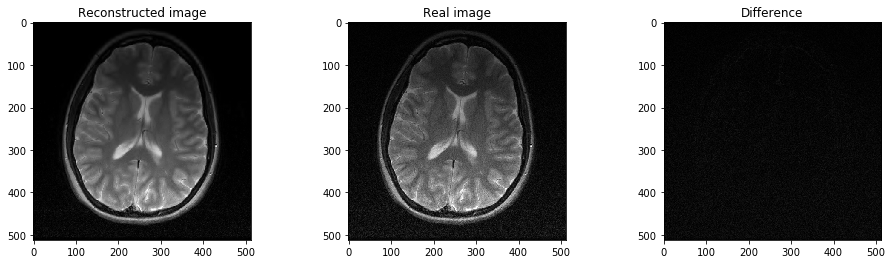

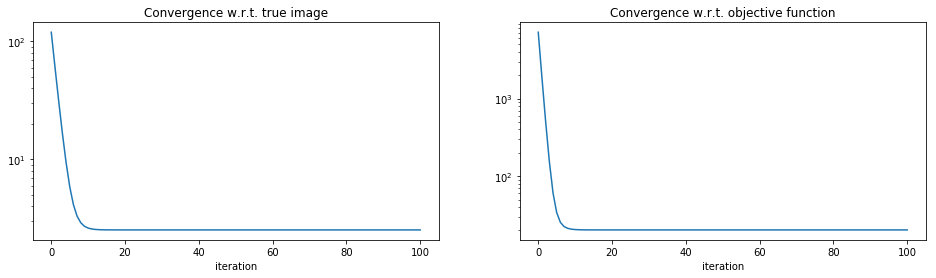

In [122]:
params['niter'] = 100
start = time.time()
ista = alg.ISTA(params)
end = time.time()
x_ista = ista.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_ista),0,1)
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x),0,1)
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_ista),0,1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iteration")
plt.semilogy(ista.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iteration")
plt.semilogy(ista.objective)
print("Iteration: ", ista.niter)
print("Initial True Error: ", ista.conv[0])
print("Final True Error: ", ista.conv[-1])
print("Initial Objective Error: ", ista.objective[0])
print("Final Objective Error: ", ista.objective[-1])
print("Time: ", end-start)

## FISTA

/Users/pagi/Research/MRI/bm4d-recon/Algorithms.py:69: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.x_init != None:


Iteration:  100
Initial True Error:  119.570244376
Final True Error:  5.06031084548e-14
Initial Objective Error:  7148.52167007
Final Objective Error:  1.35314863923e-27
Time:  48.2873318195343


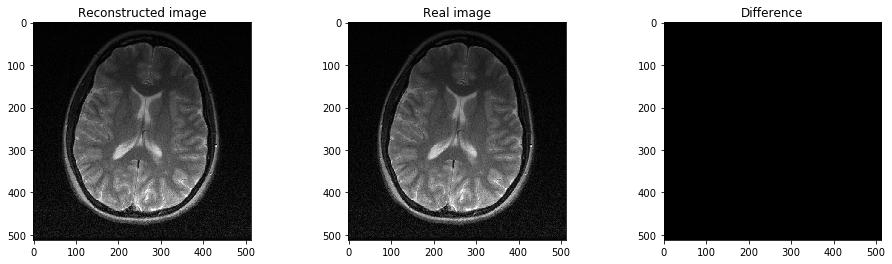

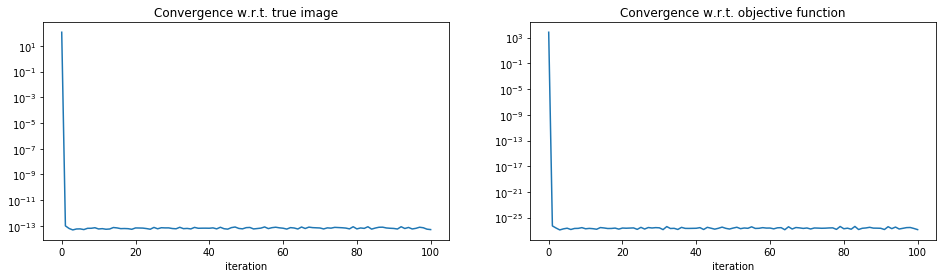

In [118]:
params['niter'] = 100
start = time.time()
fista = alg.FISTA(params)
end = time.time()
x_fista = fista.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_fista),0,1)
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x),0,1)
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_fista),0,1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iteration")
plt.semilogy(fista.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iteration")
plt.semilogy(fista.objective)
print("Iteration: ", fista.niter)
print("Initial True Error: ", fista.conv[0])
print("Final True Error: ", fista.conv[-1])
print("Initial Objective Error: ", fista.objective[0])
print("Final Objective Error: ", fista.objective[-1])
print("Time: ", end-start)

## ADMM

Iteration:  100
Initial True Error:  17.9764676647
Final True Error:  17.2364853711
Initial Objective Error:  0.167387950632
Final Objective Error:  0.16939645729
Time:  130.95485305786133


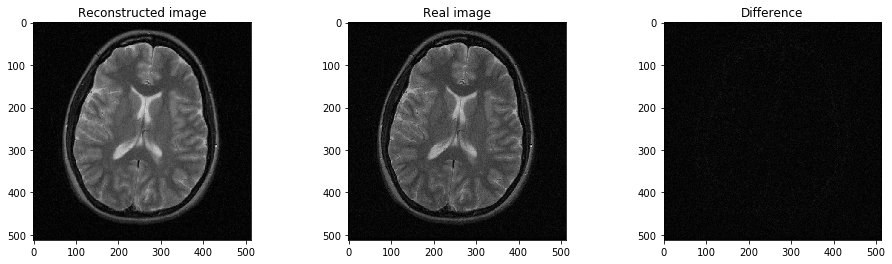

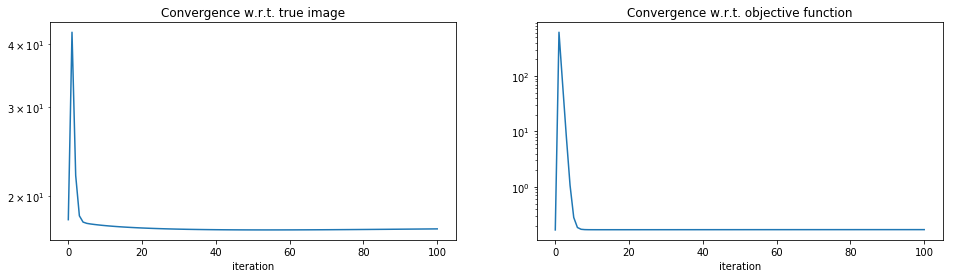

In [37]:
params['niter'] = 100
start = time.time()
admm = alg.ADMM(params)
end = time.time()
x_admm = admm.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_admm))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_admm),0,1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iteration")
plt.semilogy(admm.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iteration")
plt.semilogy(admm.objective)
print("Iteration: ", admm.niter)
print("Initial True Error: ", admm.conv[0])
print("Final True Error: ", admm.conv[-1])
print("Initial Objective Error: ", admm.objective[0])
print("Final Objective Error: ", admm.objective[-1])
print("Time: ", end-start)

## AM

In [ ]:
params['niter'] = 150
lst = [10**(-i) for i in range(6)]
for t_m in lst:
    params['t_m'] = t_m
    for t_p in lst:
        params['t_p'] = t_p
        start = time.time()
        am = alg.AM(params)
        end = time.time()
        x_am = am.result
#         plt.figure(figsize=(16,4))
#         plt.subplot(1,3,1)
#         plt.title("Reconstructed image")
#         ap.imshowgray(np.abs(x_am))
#         plt.subplot(1,3,2)
#         plt.title("Real image")
#         ap.imshowgray(np.abs(x))
#         plt.subplot(1,3,3)
#         plt.title("Difference")
#         ap.imshowgray(np.abs(x - x_am),0,1)
        plt.figure(figsize=(16,4))
        plt.subplot(1,2,1)
        plt.title("Convergence w.r.t. true image")
        plt.xlabel("iteration")
        plt.semilogy(am.conv)
        plt.subplot(1,2,2)
        plt.title("Convergence w.r.t. objective function")
        plt.xlabel("iteration")
        plt.semilogy(am.objective)
        plt.show()
        print("t_m = " + str(t_m) + ", t_p = " + str(t_p))
        print("Iteration: ", am.niter)
        print("Initial True Error: ", am.conv[0])
        print("Final True Error: ", am.conv[-1])
        print("Initial Objective Error: ", am.objective[0])
        print("Final Objective Error: ", am.objective[-1])
        print("Time: ", end-start)
        print("")

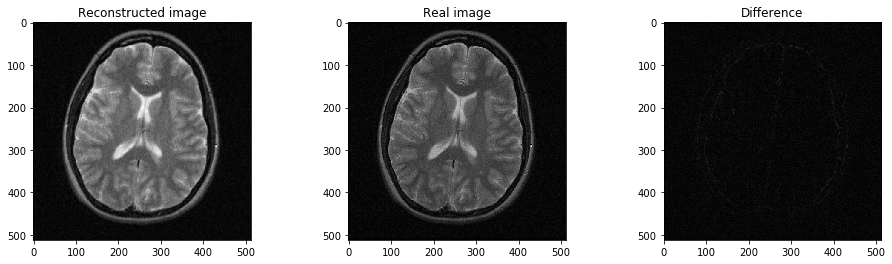

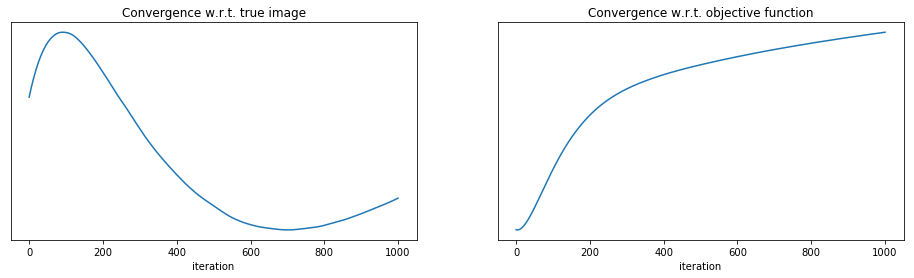

t_m = 1e-05, t_p = 1e-05
Iteration:  1000
Initial True Error:  2.1202946393
Final True Error:  2.11901474709
Initial Objective Error:  0.167387950632
Final Objective Error:  0.168883075589
Time:  915.0463540554047



In [53]:
params['niter'] = 1000
params['t_m'] = 0.01
params['t_p'] = 0.0001
start = time.time()
am = alg.AM(params)
end = time.time()
x_am = am.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_am))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_am),0,1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iteration")
plt.semilogy(am.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iteration")
plt.semilogy(am.objective)
plt.show()
# print("t_m = " + str(t_m) + ", t_p = " + str(t_p))
print("Iteration: ", am.niter)
print("Initial True Error: ", am.conv[0])
print("Final True Error: ", am.conv[-1])
print("Initial Objective Error: ", am.objective[0])
print("Final Objective Error: ", am.objective[-1])
print("Time: ", end-start)
print("")

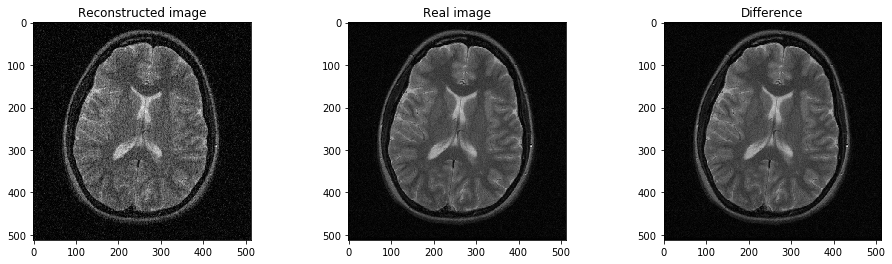

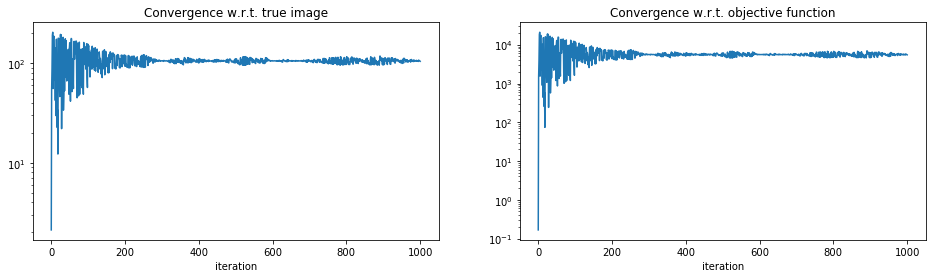

Iteration:  1000
Initial True Error:  2.1202946393
Final True Error:  104.711861883
Initial Objective Error:  0.167387950632
Final Objective Error:  5480.02778453
Time:  1294.4723479747772



In [54]:
params['niter'] = 1000
params['t_m'] = 0.01
params['t_p'] = 0.0001
start = time.time()
am = alg.AM(params)
end = time.time()
x_am = am.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_am))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_am),0,1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iteration")
plt.semilogy(am.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iteration")
plt.semilogy(am.objective)
plt.show()
# print("t_m = " + str(t_m) + ", t_p = " + str(t_p))
print("Iteration: ", am.niter)
print("Initial True Error: ", am.conv[0])
print("Final True Error: ", am.conv[-1])
print("Initial Objective Error: ", am.objective[0])
print("Final Objective Error: ", am.objective[-1])
print("Time: ", end-start)
print("")

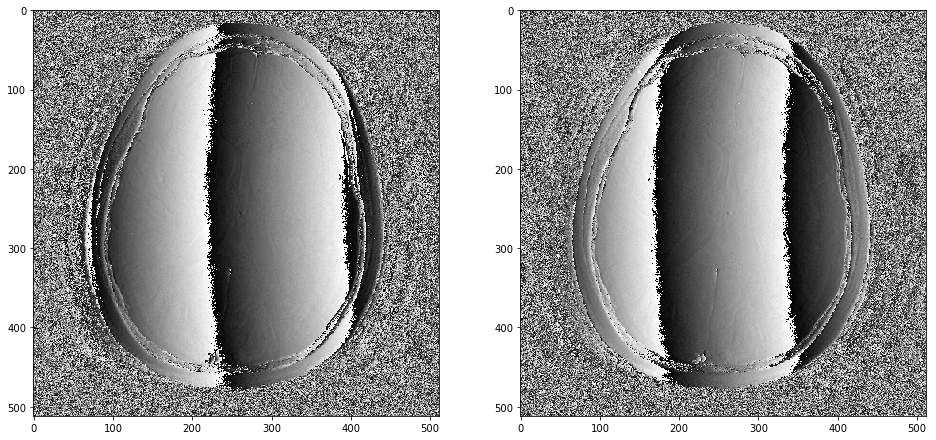

In [127]:
plt.figure()
plt.subplot(1,2,1)
ap.imshowgray(np.angle(x))
plt.subplot(1,2,2)
ap.imshowgray(np.angle(x*np.exp(1j*np.random.uniform(-np.pi,np.pi))))

## Summary

### Magnitude

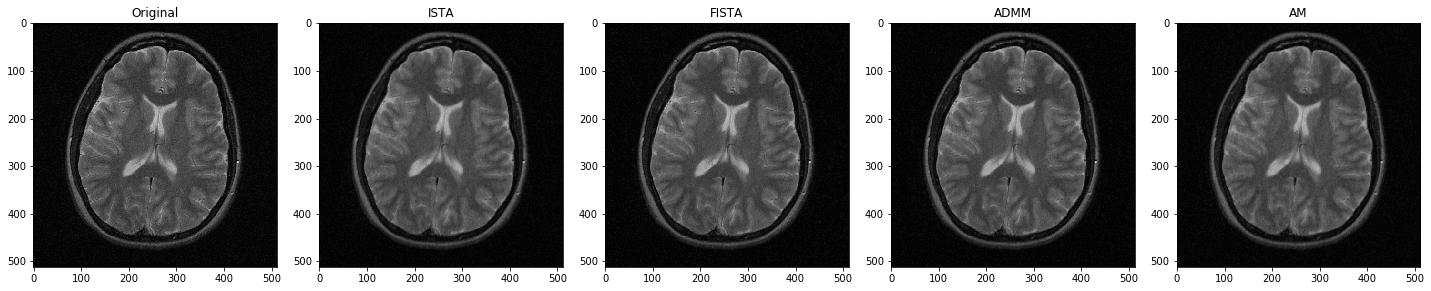

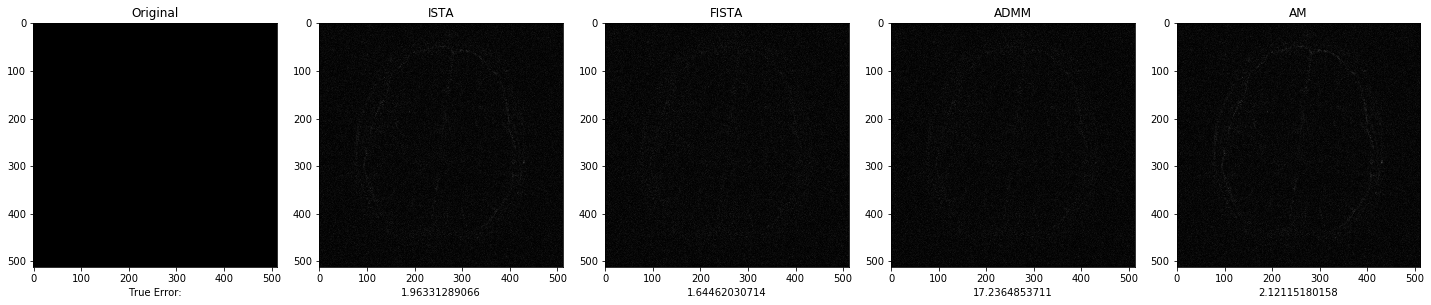

In [39]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.title('Original')
ap.imshowgray(np.abs(x))
plt.subplot(1,5,2)
plt.title('ISTA')
ap.imshowgray(np.abs(x_ista),0,1)
plt.subplot(1,5,3)
plt.title('FISTA')
ap.imshowgray(np.abs(x_fista),0,1)
plt.subplot(1,5,4)
plt.title('ADMM')
ap.imshowgray(np.abs(x_admm),0,1)
plt.subplot(1,5,5)
plt.title('AM')
ap.imshowgray(np.abs(x_am),0,1)
plt.tight_layout()

plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.title('Original')
plt.xlabel("True Error:")
ap.imshowgray(np.abs(x - x))
plt.subplot(1,5,2)
plt.title('ISTA')
plt.xlabel(ista.conv[-1])
ap.imshowgray(np.abs(x - x_ista),0,1)
plt.subplot(1,5,3)
plt.title('FISTA')
plt.xlabel(fista.conv[-1])
ap.imshowgray(np.abs(x - x_fista),0,1)
plt.subplot(1,5,4)
plt.title('ADMM')
plt.xlabel(admm.conv[-1])
ap.imshowgray(np.abs(x - x_admm),0,1)
plt.subplot(1,5,5)
plt.title('AM')
plt.xlabel(am.conv[-1])
ap.imshowgray(np.abs(x - x_am),0,1)
plt.tight_layout()

### Phase

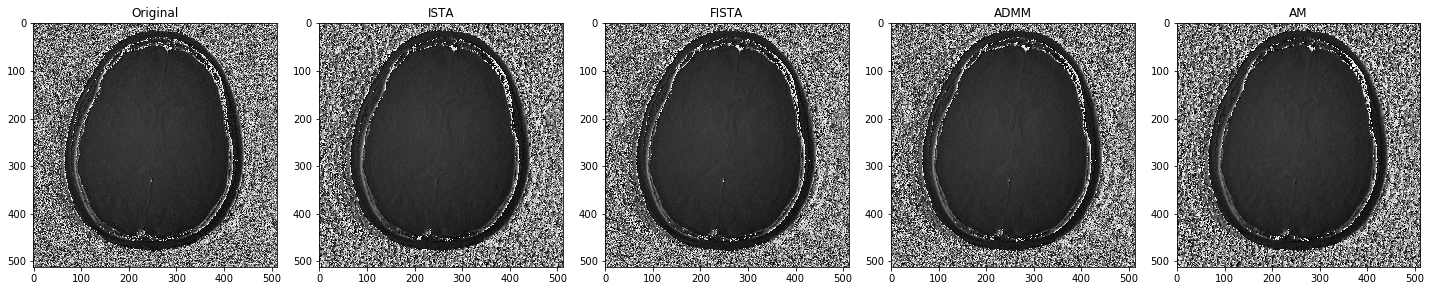

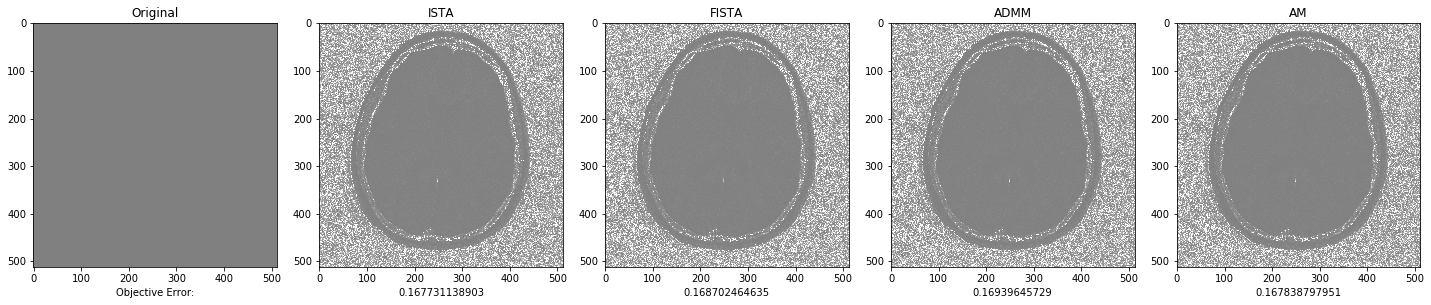

In [40]:
# np.angle correction:
# def corr(C):
#     return np.where((C > -1e-10) & (C < 1e-10))
# x_ista[corr(x_ista)] = +0
# x_fista[corr(x_fista)] = +0
# x_admm[corr(x_admm)] = +0
# x_am[corr(x_am)] = +0

plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.title('Original')
ap.imshowgray(np.angle(x),-np.pi,np.pi)
plt.subplot(1,5,2)
plt.title('ISTA')
ap.imshowgray(np.angle(x_ista),-np.pi,np.pi)
plt.subplot(1,5,3)
plt.title('FISTA')
ap.imshowgray(np.angle(x_fista),-np.pi,np.pi)
plt.subplot(1,5,4)
plt.title('ADMM')
ap.imshowgray(np.angle(x_admm),-np.pi,np.pi)
plt.subplot(1,5,5)
plt.title('AM')
ap.imshowgray(np.angle(x_am),-np.pi,np.pi)
plt.tight_layout()

plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.title('Original')
plt.xlabel("Objective Error:")
ap.imshowgray(np.abs(x - x),-np.pi,np.pi)
plt.subplot(1,5,2)
plt.title('ISTA')
plt.xlabel(ista.objective[-1])
ap.imshowgray(np.abs(np.angle(x) - np.angle(x_ista)),-np.pi,np.pi)
plt.subplot(1,5,3)
plt.title('FISTA')
plt.xlabel(fista.objective[-1])
ap.imshowgray(np.abs(np.angle(x) - np.angle(x_fista)),-np.pi,np.pi)
plt.subplot(1,5,4)
plt.title('ADMM')
plt.xlabel(admm.objective[-1])
ap.imshowgray(np.abs(np.angle(x) - np.angle(x_admm)),-np.pi,np.pi)
plt.subplot(1,5,5)
plt.title('AM')
plt.xlabel(am.objective[-1])
ap.imshowgray(np.abs(np.angle(x) - np.angle(x_admm)),-np.pi,np.pi)
plt.tight_layout()

### Convergence 

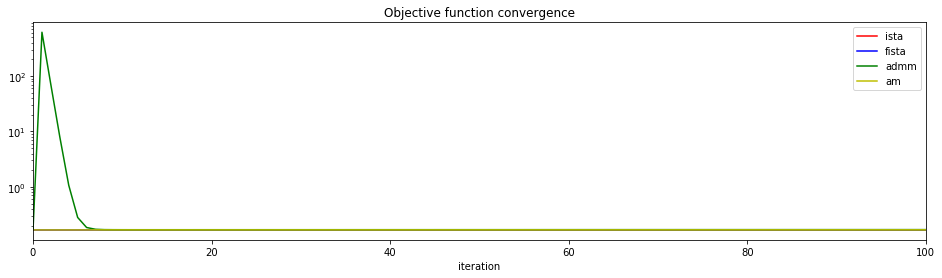

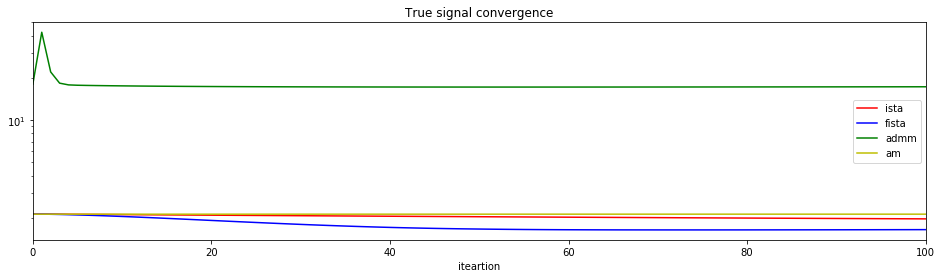

In [41]:
t = range(admm.niter + 1)

plt.figure(figsize=(16,4))
plt.title('Objective function convergence')
plt.xlabel('iteration')
plt.semilogy(t, ista.objective, 'r', label='ista')
plt.semilogy(t, fista.objective, 'b', label='fista')
plt.semilogy(t, admm.objective, 'g', label='admm')
plt.semilogy(t, am.objective, 'y', label='am')
plt.xlim((0,100))
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.title('True signal convergence')
plt.xlabel('iteartion')
plt.semilogy(t, ista.conv, 'r', label='ista')
plt.semilogy(t, fista.conv, 'b', label='fista')
plt.semilogy(t, admm.conv, 'g', label='admm')
plt.semilogy(t, am.conv, 'y', label='am')
plt.xlim((0,100))
plt.legend()
plt.show()